In [ ]:
# default_exp examples.causal_lm_gpt2

In [ ]:
#all_slow

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Causal Language Modeling with GPT-2

> This notebook demonstrates how we can use Blurr to train, or fine-tune, a causal language model against examples defined in individual files (similar to how the raw wiki-103 data comes). We demonstrate how to use `get_text_files` and create a custom `splitter` function to build our train and validation datasets.

In [ ]:
#export
from transformers import *
from fastai.text.all import *

from blurr.utils import *
from blurr.data.core import *
from blurr.data.language_modeling import *
from blurr.modeling.core import *
from blurr.modeling.language_modeling import *

logging.set_verbosity_error()

In [ ]:
#hide_input
import pdb

from fastcore.test import *
from nbverbose.showdoc import show_doc

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("Here's what we're running with ...\n")
print_versions('torch fastai transformers')

Here's what we're running with ...

torch: 1.7.1
fastai: 2.5.0
transformers: 4.9.2


In [ ]:
#cuda
#hide
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Get your data

In [ ]:
raw_data_path = Path('./data/task-language-modeling/pt-2/')
raw_data_path.ls()

(#3) [Path('data/task-language-modeling/pt-2/valid'),Path('data/task-language-modeling/pt-2/train'),Path('data/task-language-modeling/pt-2/test')]

In [ ]:
(raw_data_path/'train').ls()

(#730) [Path('data/task-language-modeling/pt-2/train/Bandeira_de_Angola.txt'),Path('data/task-language-modeling/pt-2/train/Pâncreas.txt'),Path('data/task-language-modeling/pt-2/train/Governo_Federal_do_Brasil.txt'),Path('data/task-language-modeling/pt-2/train/Monte_da_Pedra.txt'),Path('data/task-language-modeling/pt-2/train/Pouso_Alegre.txt'),Path('data/task-language-modeling/pt-2/train/Ararinha-azul.txt'),Path('data/task-language-modeling/pt-2/train/Deus.txt'),Path('data/task-language-modeling/pt-2/train/Ernest_Hemingway.txt'),Path('data/task-language-modeling/pt-2/train/Brasileiros.txt'),Path('data/task-language-modeling/pt-2/train/Distrito_de_Beja.txt')...]

In [ ]:
len((raw_data_path/'train').ls()), len((raw_data_path/'valid').ls())

(730, 56)

## Get your HF objects

In [ ]:
model_cls = AutoModelForCausalLM

pretrained_model_name = "gpt2"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=model_cls)

if (hf_tokenizer.pad_token is None): 
    hf_tokenizer.add_special_tokens({'pad_token': '<pad>'})  
    hf_config.pad_token_id = hf_tokenizer.get_vocab()['<pad>']
    hf_model.resize_token_embeddings(len(hf_tokenizer))

Using pad_token, but it is not set yet.


## Build your DataBlock

### Define how to get the raw data

In [ ]:
# the folders we want to grab the files from
get_wiki_files = partial(get_text_files, folders=['train', 'valid'])

In [ ]:
fnames = get_wiki_files(raw_data_path)

In [ ]:
fnames[0]

Path('data/task-language-modeling/pt-2/valid/Hipótese_de_Riemann.txt')

### Define how we want to split our validation and training datasets

In [ ]:
# custom splitter to split on parent folder name
splitter = FuncSplitter(lambda fpath: Path(fpath).parent.name == 'valid')

In [ ]:
splitter(fnames)

((#730) [56,57,58,59,60,61,62,63,64,65...], (#56) [0,1,2,3,4,5,6,7,8,9...])

### Define our DataBlock using the appropriate Blurr transforms

In [ ]:
# our before_batch_tfm and HF_TextBlock updated for causal modeling task
bbtfm = HF_LMBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, lm_strategy_cls=CausalLMStrategy)
blocks = (HF_TextBlock(before_batch_tfm=bbtfm, input_return_type=HF_CausalLMInput), noop)

# our DataBlock
dblock = DataBlock(
    blocks=blocks, 
    get_x=lambda x: x.read_text(),   # read each text file
    get_items=get_wiki_files,        # grab the text files
    splitter=splitter                # split on parent folder name (validation = 'valid')
)

In [ ]:
# dblock.summary(raw_data_path)

In [ ]:
dls = dblock.dataloaders(raw_data_path, bs=2, val_bs=4)

In [ ]:
b = dls.one_batch()

In [ ]:
b[0]['input_ids'].shape, b[1].shape

(torch.Size([2, 1024]), torch.Size([2, 1024]))

In [ ]:
dls.show_batch(dataloaders=dls, trunc_at=500, max_n=2)

,text,target
0,"Aquecimento global é o processo de aumento da temperatura média dos oceanos e da atmosfera da Terra causado por massivas emissões de gases que intensificam o efeito estufa, originados de uma série de atividades humanas, especialmente a queima de combustíveis fósseis e mudanças no uso da terra, como o desmatamento, bem como de várias outras fontes secundárias. Essas causas são um produto direto da explosão populacional, do crescimento econômico, do uso de tecnologias e fontes de energia poluidor","ecimento global é o processo de aumento da temperatura média dos oceanos e da atmosfera da Terra causado por massivas emissões de gases que intensificam o efeito estufa, originados de uma série de atividades humanas, especialmente a queima de combustíveis fósseis e mudanças no uso da terra, como o desmatamento, bem como de várias outras fontes secundárias. Essas causas são um produto direto da explosão populacional, do crescimento econômico, do uso de tecnologias e fontes de energia poluidoras e"
1,"Anarquismo é uma ideologia política que se opõe a todo tipo de hierarquia e dominação, seja ela política, econômica, social ou cultural, como o Estado, o capitalismo, as instituições religiosas, o racismo e o patriarcado. Através de uma análise crítica da dominação, o anarquismo pretende superar a ordem social na qual esta se faz presente através de um projeto construtivo baseado na defesa da autogestão, tendo em vista a constituição de uma sociedade libertária baseada na cooperação e na ajuda","arquismo é uma ideologia política que se opõe a todo tipo de hierarquia e dominação, seja ela política, econômica, social ou cultural, como o Estado, o capitalismo, as instituições religiosas, o racismo e o patriarcado. Através de uma análise crítica da dominação, o anarquismo pretende superar a ordem social na qual esta se faz presente através de um projeto construtivo baseado na defesa da autogestão, tendo em vista a constituição de uma sociedade libertária baseada na cooperação e na ajuda mút"


## Train

In [ ]:
model = HF_BaseModelWrapper(hf_model)
fit_cbs = [LM_MetricsCallback()]

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=HF_PreCalculatedLoss(),
                cbs=[HF_BaseModelCallback],
                metrics=[perplexity],
                splitter=hf_splitter).to_fp16()

# learn.freeze()

/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(minimum=0.03019951581954956, steep=0.25118863582611084, valley=0.0002754228771664202, slide=0.2089296132326126)

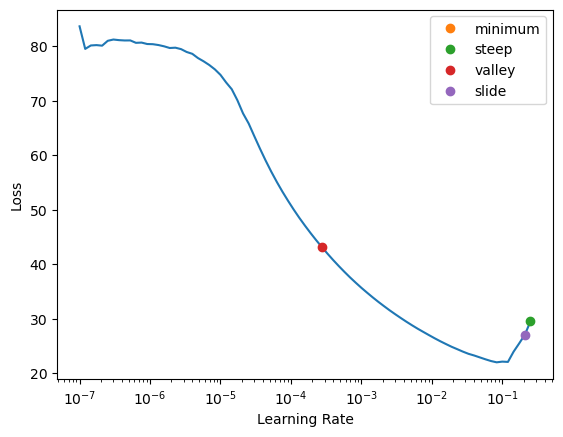

In [ ]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(1, lr_max=3e-3, cbs=fit_cbs)

epoch,train_loss,valid_loss,perplexity,lm_accuracy,time
0,3.236847,3.147343,23.274141,0.420775,02:29


In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"A Idade Média ( adj. medieval ) é um período da história da Europa entre os séculos V e XV. Inicia-se com a Queda do Império Romano do Ocidente e termina durante a transição para a Idade Moderna. A Idade Média é o período intermédio da divisão clássica da História ocidental em três períodos : a Antiguidade, Idade Média e Idade Moderna, sendo frequentemente dividido em Alta e Baixa Idade Média.\nDurante a Alta Idade Média verifica-se a continuidade dos processos de despovoamento, regressão urbana","Idade Média ( adj. medieval ) é um período da história da Europa entre os séculos V e XV. Inicia-se com a Queda do Império Romano do Ocidente e termina durante a transição para a Idade Moderna. A Idade Média é o período intermédio da divisão clássica da História ocidental em três períodos : a Antiguidade, Idade Média e Idade Moderna, sendo frequentemente dividido em Alta e Baixa Idade Média.\nDurante a Alta Idade Média verifica-se a continuidade dos processos de despovoamento, regressão urbana,","oade dodia ( )og ), é um filíodo de �ória do �,re as seéculos X, VIII\nicialisse ao �úa, Histério doano, Sulceidentale, aouçante o suição da a �ade Méa.\n Idade Média é um período daaédio da Europaisão doássica, Europaória,cident. queês histíodos.\n Idiguaade Mé aade Média, aade Méa. ao aemente aida com trgar. aixo,ade Média.\nAante a Idente,ade Média,da-se aoarade de �os de �óamento, aando ebana, a aasão�es deritsicculas.iciados.ante a suiguidade Mééa.\n processuados sárbaras deam- sos deos de aóu a"
1,"Itália ( ), oficialmente República Italiana, é uma república parlamentar unitária localizada no centro-sul da Europa. Ao norte, faz fronteira com França, Suíça, Áustria e Eslovênia ao longo dos Alpes. A parte sul consiste na totalidade da península Itálica, Sicília, Sardenha, as duas maiores ilhas no mar Mediterrâneo, e muitas outras ilhas menores ficam no entorno do território italiano. Os Estados independentes de San Marino e do Vaticano são enclaves no interior da Itália, enquanto Campione d","ália ( ), oficialmente República Italiana, é uma república parlamentar unitária localizada no centro-sul da Europa. Ao norte, faz fronteira com França, Suíça, Áustria e Eslovênia ao longo dos Alpes. A parte sul consiste na totalidade da península Itálica, Sicília, Sardenha, as duas maiores ilhas no mar Mediterrâneo, e muitas outras ilhas menores ficam no entorno do território italiano. Os Estados independentes de San Marino e do Vaticano são enclaves no interior da Itália, enquanto Campione d &a","oc do ) é éicialmente,ública dea, com umma subública dequeentoá aári doizada na Brasro (ameró, Uni. É see com comaz fronteira com oa e comíça e S�rearia, �spanâinanc,o longo de paente.\n suir da doe em �idade de �ínsula,áliaa, comarilia, Sãoa, S Fas �aisores dohas, cent,iterrâno, e aaiso mras dehas deos doazou- sulanto. paório.aliano.\n seados Unes do S Marino, S Brasouano,ão aada com territ do �álic, comanto ao daasquos; Oá & a territíreg doaliano. regíça.\n território It territís érang aerca de 1"


In [ ]:
learn.blurr_generate('Itália ( ), oficialmente República Italiana', max_length=100, do_sample=True, top_k=25)

[' Itália ( ), oficialmente República Italiana , em 1794 , de acordo da República Sudeste ( ou país ) , constituído por &quot; Países &quot; , &quot; Repúblicas &quot; ( em 1724 e 1849 ) a sua região estatística do distrito da República Europeia ,']

## Summary

This example demonstrates how to train a causal language model where the raw data examples are in individual files (similar to how the standard wikitext-103 is defined). We also defined a custom `splitter` function so as to put all the files under `/valid` as part of the validation set and all the files under `/train` in the training set.

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01_modeling-core.ipynb.
Converted 02_data-language-modeling.ipynb.
Converted 02_modeling-language-modeling.ipynb.
Converted 03_data-token-classification.ipynb.
Converted 03_modeling-token-classification.ipynb.
Converted 04_data-question-answering.ipynb.
Converted 04_modeling-question-answering.ipynb.
Converted 10_data-seq2seq-core.ipynb.
Converted 10_modeling-seq2seq-core.ipynb.
Converted 11_data-seq2seq-summarization.ipynb.
Converted 11_modeling-seq2seq-summarization.ipynb.
Converted 12_data-seq2seq-translation.ipynb.
Converted 12_modeling-seq2seq-translation.ipynb.
Converted 99a_examples-high-level-api.ipynb.
Converted 99b_examples-glue.ipynb.
Converted 99c_examples-glue-plain-pytorch.ipynb.
Converted 99d_examples-multilabel.ipynb.
Converted 99e_examples-causal-lm-gpt2.ipynb.
Converted index.ipynb.
